# Implémentation de Grad Cam

## Packages et lecture du code

** IMPORTANT : à changer si utilisation du CPU ou du GPU **

In [1]:
from pathlib import Path

current_dir = Path.cwd()  # this points to 'notebooks/' folder
proj_path = current_dir.parent.parent 
print(proj_path)

C:\Users\wenceslas\Documents\cours\ENSAE\2A\Normal\statapp\nlp_understanding


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset
import pickle
import pandas as pd
from torch.autograd import Variable
import numpy as np

from src.deep_nlp.embed_cnn.embcnnmodel_gradcam import classifier3F

In [3]:
device = torch.device('cpu')
batch_size = 1

### Lecture de la classe `classifier3F`

In [4]:
import os
path_cnn_model_class = os.path.join(proj_path,"src","deep_nlp","embed_cnn","embcnnmodel.py")

## Lecture des modèles déjà entraînés

### Lecture des données

In [5]:
path_dataset_train = os.path.join(proj_path,"data","02_intermediate","allocine_train_inter.csv")
path_dataset_valid = os.path.join(proj_path,"data","02_intermediate","allocine_valid_inter.csv")
path_dataset_test = os.path.join(proj_path,"data","02_intermediate","allocine_test_inter.csv")

train_data = pd.read_csv(path_dataset_train, dtype = "int64")
val_data = pd.read_csv(path_dataset_valid, dtype = "int64")
test_data = pd.read_csv(path_dataset_test, dtype = "int64")
test_data_copy= test_data.copy()

train_tensor_x = torch.from_numpy(train_data.drop(columns=["label"]).to_numpy()).to(device).long()
train_tensor_y = torch.from_numpy(train_data["label"].to_numpy()).to(device).long()

val_tensor_x = torch.from_numpy(val_data.drop(columns=["label"]).to_numpy()).to(device).long()
val_tensor_y = torch.from_numpy(val_data["label"].to_numpy()).to(device).long()

test_tensor_x = torch.from_numpy(test_data.drop(columns=["label"]).to_numpy()).to(device).long()
test_tensor_y = torch.from_numpy(test_data["label"].to_numpy()).to(device).long()

train_data = TensorDataset(train_tensor_x,train_tensor_y)
test_data = TensorDataset(test_tensor_x, test_tensor_y)
valid_data = TensorDataset(val_tensor_x, val_tensor_y)

train_load = torch.utils.data.DataLoader(dataset=train_data,
                            batch_size=batch_size,
                            shuffle=False)
val_load = torch.utils.data.DataLoader(dataset= valid_data,
                            batch_size=batch_size,
                            shuffle=False)
test_load = torch.utils.data.DataLoader(dataset= test_data,
                            batch_size=batch_size,
                            shuffle=False)

### Création d'un dictionnaire contenant le vocabulaire

In [6]:
path_vocab = os.path.join(proj_path,"data","04_feature","voc.pkl")

#Embedding reading
with open(path_vocab, 'rb') as f:
    vocab = pickle.load(f)   

In [7]:
vocab_reverse = {y:x for x,y in vocab.items()}

### Lecture de l'embedding (Word2vec French) sauvegardé

In [8]:
path_embed_pytorch = os.path.join(proj_path,"data","04_feature","w2v_torch.pkl")

#Embedding reading
with open(path_embed_pytorch, 'rb') as f:
    embed_for_torch = pickle.load(f)

### Création d'un dictionnaire contenant les paramètres pour le modèle

In [9]:
params_models = {"wv": embed_for_torch,"no_words": 67,"embedding_dim":200, "nb_filter":600
                 , "height_filter":tuple([1, 2]), "output_dim":2, "dropout":0.6, "padded":True}

### Lecture du modèle

In [10]:
path_trained_model = os.path.join(proj_path,"data","06_models","embed_cnn","embed_cnn_classifier"
                                  ,"embed_cnn.pt")

#Embedding reading
with open(path_trained_model, 'rb') as f:
    model_weight = pickle.load(f)

model = classifier3F(**params_models)

model.load_state_dict(model_weight)
model.eval()

classifier3F(
  (before_conv): Sequential(
    (conv1_conv_1): Conv2d(1, 600, kernel_size=(1, 200), stride=(1, 1))
    (conv1_conv_2): Conv2d(1, 600, kernel_size=(2, 200), stride=(1, 1))
    (conv1_relu): ReLU()
  )
  (pool): Sequential(
    (conv1_maxpool): Sequential(
      (0): MaxPool1d(kernel_size=67, stride=1, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (after_conv): Sequential(
    (dp): Dropout(p=0.6, inplace=False)
    (fc): Linear(in_features=1200, out_features=2, bias=True)
    (sm): Softmax(dim=1)
  )
  (embedding): Embedding(155564, 200)
  (conv1_conv): ModuleList(
    (0): Conv2d(1, 600, kernel_size=(1, 200), stride=(1, 1))
    (1): Conv2d(1, 600, kernel_size=(2, 200), stride=(1, 1))
  )
  (conv1_relu): ReLU()
  (conv1_maxpool): Sequential(
    (0): MaxPool1d(kernel_size=67, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=1200, out_features=2, bias=True)
  (sm): Softmax(dim=1)
  (dp): Dropout(p=0.6, inplace=False)
)

### Vérification

In [11]:
# #Text test
# # test_text,_ = next(iter(test_load))
# # output_test= model(test_text)

# model.get_heatmap(text= test_text
#                 , num_class= 0
#                 , dim= [0, 2]
#                 , type_map= "normalized")

In [12]:
pred_test = []
lab = []

with torch.no_grad():
    for review,label in test_load:
        pred_test.append(model(review))
        lab.append(label.float())

In [77]:
pred_test = torch.cat(pred_test).cpu()
lab = torch.cat(lab).cpu()
#define metric
def binary_accuracy(preds, y):
    #round predictions to the closest integer
    rounded_preds = torch.round(preds[:,1])    
    correct = (rounded_preds == y).float() 
    acc = correct.sum() / len(correct)
    return acc

binary_accuracy(pred_test, lab.float())

TypeError: expected Tensor as element 0 in argument 0, but got numpy.float32

## GradCam

### Création de la classe GradCam

Pour l'instant, j'essaye d'implémenter GradCam uniquement pour le modèle Embedding + CNN. Je modifirai la classe plus tard pour qu'elle soit plus générale.
Il faudra peut être utiliser `test = [element for element in model.modules()]`

In [14]:
%%time

index_nothing= np.array([155563, 155562])
seuil= 0.75
class_explanation= 0

pred_test= []
lab = []
results = []
results_value= []
i = 0

heatmap_error= []

model.eval()
for review, label in test_load:
    # Prediction / label
    output= model(review)
    lab.append(label.float())
    
    text_index= review.squeeze().numpy()
    
    explanations_class_one= model.get_heatmap(text= review
                                    , num_class= class_explanation
                                    , dim= [0, 2]
                                    , type_map= "max")[-1]

#     res = pd.DataFrame(
#         {"index": text_index
#         , "explanations": explanations_class_one
#         })
    
#     res["word"] = pd.Series([vocab_reverse.get(index, "") for index in text_index])
#     res.sort_values(by='explanations', ascending=False, inplace = True)
#     res= res[~res["index"].isin(index_nothing)]
    
#     mots_expliquants = list(res[res["explanations"] > seuil]["word"])
#     explications_pour_plot= {"mots_expli": mots_expliquants
#                              , "prob": output[0, 1].item()}
    
    ### test
    word= np.array([vocab_reverse.get(index, "") for index in text_index])
    # if index word is in the list whe dont want, we capture its index
    selected_word_bool= np.in1d(text_index, index_nothing)
    # Get index of word we want
    selected_word_index= np.where(~selected_word_bool)[0]
    
    # Get the valeu and word from the index
    selected_word= word[selected_word_index]
    selected_explanation= explanations_class_one[selected_word_index]
    
    # Condition words selected by a threshold
    best_word_explanation_index= np.where(selected_explanation >= seuil)[0]
    best_word_explanation= selected_word[best_word_explanation_index]
    best_explanation_value= selected_explanation[best_word_explanation_index]
    
    # Sort by the value (descending order)
    sort_per_explanation_index= np.argsort(best_word_explanation)[::-1] # [::-1] to get the highest first
    best_word_explanation= best_word_explanation[sort_per_explanation_index]
    best_explanation_value= best_explanation_value[sort_per_explanation_index] # Useless but tasty boy
    
    
    
    explications_pour_plot= {"mots_expli": best_word_explanation
                             , "prob": output[0, 1].item()}
    
    results.append([explications_pour_plot, label])
    pred_test.append(output[:,1].detach().numpy()[0])
    
    
#     if i == 1500:
#         break
    
    i += 1
    if i % 100 == 0:
        print(i)

100
200


C:\Users\wenceslas\Documents\cours\ENSAE\2A\Normal\statapp\nlp_understanding\src\deep_nlp\grad_cam\model\gradcam_base_model.py:105: RuntimeWarning: invalid value encountered in true_divide
  heatmap /= max_heatmap_value


300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18500
18600


In [15]:
# okok= os.path.join(proj_path,"data","01_raw","allocine_test.csv")
# test_data_copy= pd.read_csv(okok)
# error_heatmap= []
# for j in range(len(results)):
#     if results[j] == []:
#         error_heatmap.append(j)
#         print(test_data_copy[test_data_copy.index == j]["review"].values)

In [63]:
mots_plus_75 = [element[0]["mots_expli"] for element in results if element[0]["prob"] > 0.75]
mots_50_75 = [element[0]["mots_expli"] for element in results if (element[0]["prob"] > 0.5) & (element[0]["prob"] < 0.75)]
mots_25_50 = [element[0]["mots_expli"] for element in results if (element[0]["prob"] > 0.25) & (element[0]["prob"] < 0.5)]
mots_0_25 = [element[0]["mots_expli"] for element in results if (element[0]["prob"] < 0.25)]

In [64]:
mots = [element[0]["mots_expli"] for element in results]
prob = [element[0]["prob"] for element in results]

In [65]:
#faire table ind pour les mots + prob puis faire une ACM

In [66]:
import itertools
mots_plus_75 = list(itertools.chain.from_iterable(mots_plus_75))
mots_50_75 = list(itertools.chain.from_iterable(mots_50_75))
mots_25_50 = list(itertools.chain.from_iterable(mots_25_50))
mots_0_25 = list(itertools.chain.from_iterable(mots_0_25))

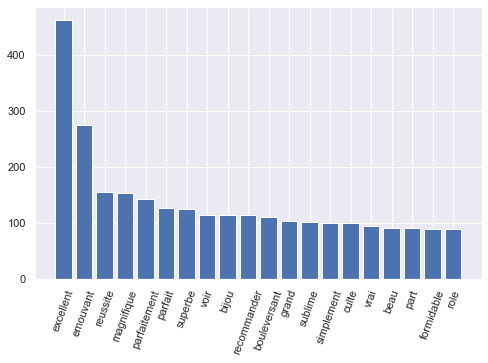

In [72]:
from collections import Counter

def plot_barplot(list_of_token, num_to_display= 20, title= None):
    w= dict(Counter(list_of_token).most_common(num_to_display))

    fig, ax = plt.subplots(figsize= (8, 5))
    ax.bar(w.keys(), w.values(), figure= None)

    ax.set_title(title)
    ax.xaxis.set_tick_params(rotation= 70)
    plt.show()
    pass

plot_barplot(mots_plus_75)

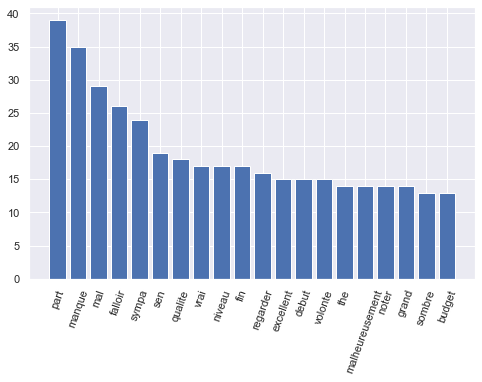

In [79]:
# mots_0_25_df = pd.DataFrame.from_dict(Counter(mots_0_25),orient="index")

# mots_0_25_df = mots_0_25_df.sort_values(by=0, ascending = False)

# mots_0_25_df.head(30).plot.bar(figure= None)

plot_barplot(mots_25_50)

In [ ]:
# Import packages
import matplotlib.pyplot as plt
%matplotlib inline
# Define a function to plot word cloud
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");

Nuage de mots pour les prédictions à plus de 75%

In [ ]:
# Import package
from wordcloud import WordCloud, STOPWORDS
# Generate word cloud
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='salmon', colormap='Pastel1', collocations=False, stopwords = STOPWORDS).generate(" ".join(mots_0_25))
# Plot
plot_cloud(wordcloud)

In [ ]:
wordcloud2 = WordCloud(width = 3000, height = 2000, random_state=1,background_color='salmon', colormap='Pastel1', collocations=False, stopwords = STOPWORDS).generate(" ".join(mots_25_50))
# Plot
plot_cloud(wordcloud2)